In [1]:
import pathlib

import numpy as np
import matplotlib.pyplot as plt

import mfe.baseclasses
import mfe.solve
import mfe.utils
import mfe.load
import mfe.plot
import mfe.elem_lib

MESH_FILES = {
    'connectivity': pathlib.Path(r'C:\Users\Michael\Documents\repos\theory_fea\project\jobs\linear\proj_mesh5_45\proj_mesh5_45_connectivity_mfe.csv'),
    'node_coords': pathlib.Path(r'C:\Users\Michael\Documents\repos\theory_fea\project\jobs\linear\proj_mesh5_45\proj_mesh5_45_nodes_mfe.csv')
}

In [2]:
# Get connectivity matrix and nodal coordinates, then assemble the mesh
G, node_coords = mfe.utils.read_mesh_from_csv(**MESH_FILES)
elems = mfe.solve.assemble_mesh(G, node_coords)

In [3]:
# Set the element material property matrix, thickness, and orientation
D = mfe.utils.D_transversely_isotropic_plane_stress(E11=231000, E22=15000, nu12=0.21, G12=15800)
T = mfe.utils.make_transform_matrix_2D(45)
thickness = 0.001
for e in elems:
    e.D = D.copy()
    e.thickness = thickness
    e.T = T.copy()

# Create displacement bc dict
disp_bcs = {'y_disp': {}, 'x_disp': {}}
APPLIED_DISP = 0.1

nodes_y0 = np.arange(1, 3, 1)
for node in nodes_y0:
    disp_bcs['x_disp'].update({node: 0})
    disp_bcs['y_disp'].update({node: 0})

nodes_y1 = np.arange(11, 13, 1)
for node in nodes_y1:
    disp_bcs['x_disp'].update({node: 0})
    disp_bcs['y_disp'].update({node: APPLIED_DISP})

In [4]:
# Assemble solution matrices
loads = [[] for _ in elems]
K, F = mfe.solve.assemble_global_solution(G, elems, loads, 2)

# Apply disp BCs
K, F = mfe.solve.apply_disp_bcs(disp_bcs['x_disp'], disp_bcs['y_disp'], K, F)

# Solve
Q = np.matmul(np.linalg.inv(K), F)

(<Figure size 1000x500 with 4 Axes>,
 array([<Axes: title={'center': 'u$_{1}$'}, xlabel='$x_{1}$', ylabel='$x_{2}$'>,
        <Axes: title={'center': 'u$_{2}$'}, xlabel='$x_{1}$', ylabel='$x_{2}$'>],
       dtype=object))

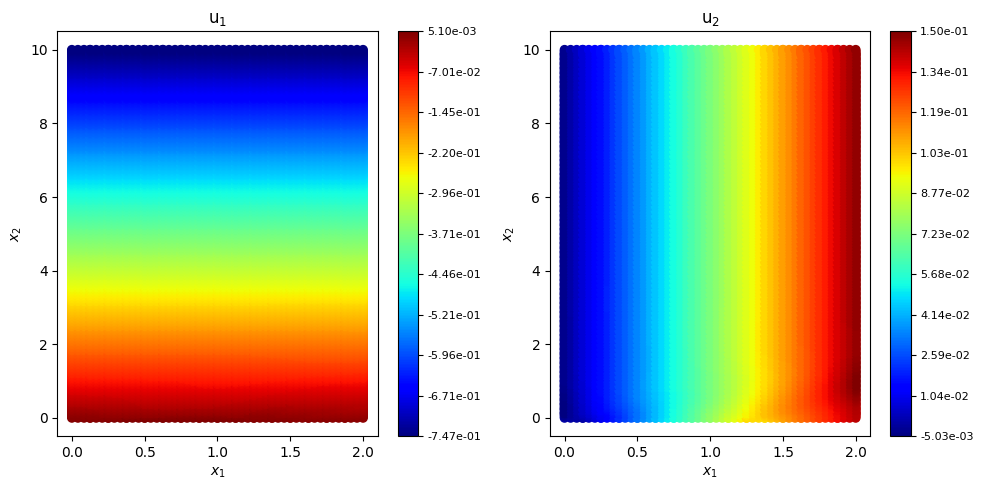

In [5]:
# Plot on assembly
natural_grid = mfe.utils.make_natural_grid(4)
x_assembly = mfe.solve.build_assembly_coord_grid(G, elems, natural_grid)
Q_assembly = mfe.solve.map_nodal_field_to_assembly(G, elems, Q, natural_grid)
mfe.plot.plot_element_displacement(Q_assembly, x_assembly, method='scatter')

[[-0.50481949]
 [-0.50481949]
 [ 0.50481949]]


{'stress': (<Figure size 1500x500 with 6 Axes>,
  array([<Axes: title={'center': '$\\sigma_{11}$'}, xlabel='$x_{1}$', ylabel='$x_{2}$'>,
         <Axes: title={'center': '$\\sigma_{22}$'}, xlabel='$x_{1}$', ylabel='$x_{2}$'>,
         <Axes: title={'center': '$\\sigma_{12}$'}, xlabel='$x_{1}$', ylabel='$x_{2}$'>],
        dtype=object)),
 'strain': (<Figure size 1500x500 with 6 Axes>,
  array([<Axes: title={'center': '$\\varepsilon_{11}$'}, xlabel='$x_{1}$', ylabel='$x_{2}$'>,
         <Axes: title={'center': '$\\varepsilon_{22}$'}, xlabel='$x_{1}$', ylabel='$x_{2}$'>,
         <Axes: title={'center': '$\\varepsilon_{12}$'}, xlabel='$x_{1}$', ylabel='$x_{2}$'>],
        dtype=object))}

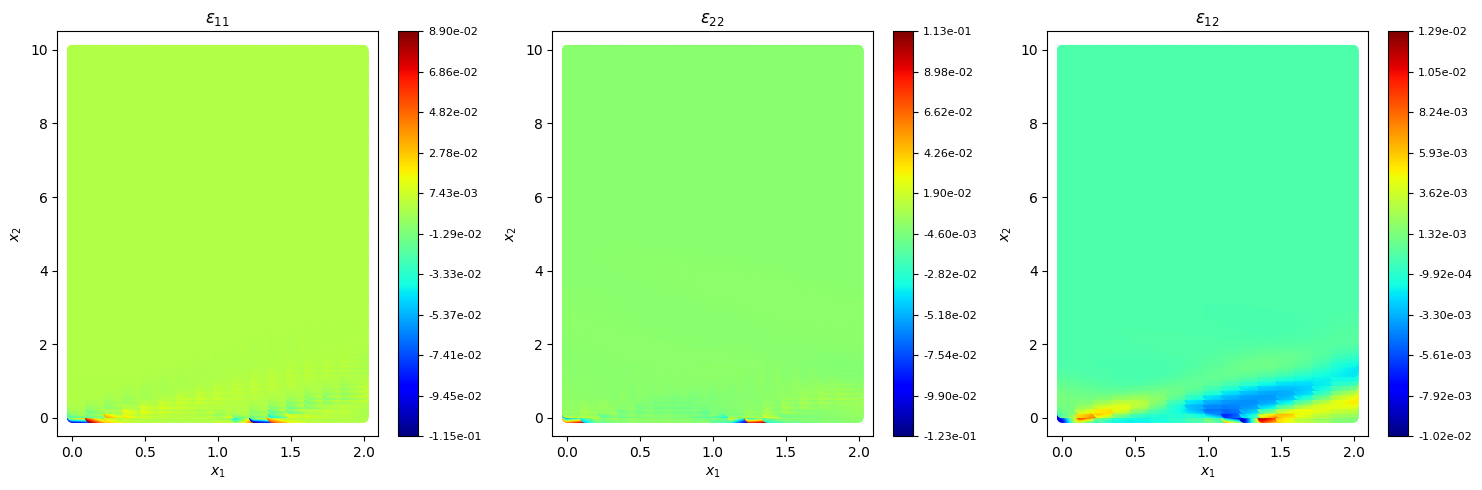

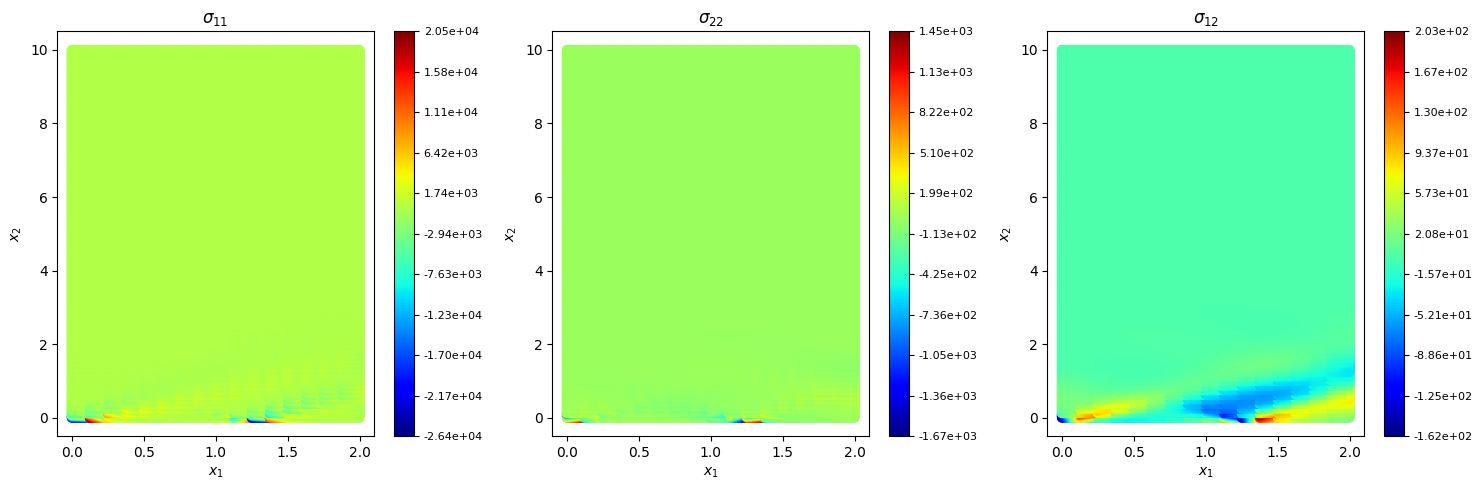

In [6]:
# Plot on assembly
natural_grid = mfe.utils.make_natural_grid(10)
x_assembly = mfe.solve.build_assembly_coord_grid(G, elems, natural_grid)
sig, eps = mfe.solve.map_stress_strain_to_assembly(G, elems, Q, natural_grid, loc_sys=True)
print(np.mean(sig, axis=(0, 1)))
mfe.plot.plot_element_stress_strain(sig, eps, x_assembly, method='scatter')